In [1]:
import numpy as np
import pandas as pd 
import os
import cv2
import pickle
import random 
import time
import zipfile
from shutil import copyfile
import struct
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense,Dropout,Activation,BatchNormalization,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adam,Adadelta
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# read data and preprocessing

In [2]:
def read_cdb(file_path):
    with open(file_path, 'rb') as binary_file:

        data = binary_file.read()
        of = 0  #offset
        y = struct.unpack_from('H', data, of)[0]
        of += 2

        m = struct.unpack_from('B', data, of)[0]
        of += 1

        d = struct.unpack_from('B', data, of)[0]
        of += 1

        H = struct.unpack_from('B', data, of)[0]
        of += 1

        W = struct.unpack_from('B', data, of)[0]
        of += 1

        TotalRec = struct.unpack_from('I', data, of)[0]
        of += 4

        LetterCount = struct.unpack_from('128I', data, of)
        of += 128 * 4

        imgType = struct.unpack_from('B', data, of)[0]  # 0: binary, 1: gray
        of += 1

        Comments = struct.unpack_from('256c', data, of)
        of += 256 * 1

        Reserved = struct.unpack_from('245c', data, of)
        of += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        imgs = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, of)[0]  # must be 0xff
            of += 1

            label = struct.unpack_from('B', data, of)[0]
            of += 1

            if not normal:
                W = struct.unpack_from('B', data, of)[0]
                of += 1

                H = struct.unpack_from('B', data, of)[0]
                of += 1

            ByteCount = struct.unpack_from('H', data, of)[0]
            of += 2

            img = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                
                for i in range(H):# Binary
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, of)[0]
                        of += 1
                        if bWhite:
                            img[i, counter:counter + WBcount] = 0  # Background
                        else:
                            img[i, counter:counter + WBcount] = 255
                        bWhite = not bWhite
                        counter += WBcount
            else:
                
                data = struct.unpack_from('{}B'.format(W * H), data, of)# GrayScale mode
                of += W * H
                img = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            imgs.append(img)
            labels.append(label)

        return imgs, labels

def preprocessing(dataset_path):
    images, labels = read_cdb(dataset_path)
    assert len(images) == len(labels)

    IMAGES = np.zeros(shape=[len(images), 40, 40], dtype=np.float32)
    LABELS = np.zeros(shape=[len(labels)], dtype=int)

    for i in range(len(images)):
        image = images[i]
        image = cv2.resize(image,(40,40))#resize
        image = image / 255 #normalization
        image = np.where(image >= 0.5, 1, 0)#binarization
        IMAGES[i] = image
        LABELS[i] = labels[i]
    LABELS = to_categorical(LABELS.astype(dtype=np.float32))# One-hot encoding label 
    return IMAGES, LABELS

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
X_train, y_train = preprocessing('/content/drive/MyDrive/Colab Notebooks/HODA/Train 60000.cdb')

In [5]:
X_test, y_test = preprocessing('/content/drive/MyDrive/Colab Notebooks/HODA/Test 20000.cdb')

# some sample of dataset in train group

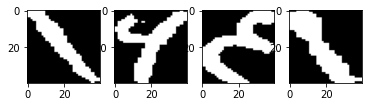

In [6]:
for i in range(4):
  j = np.random.randint(0,len(X_train))
  plt.subplot(140 + (i+1))
  plt.imshow(X_train[j].squeeze(), cmap=plt.get_cmap('gray'))

# DCNN Model

In [7]:
model = Sequential()

# 1st Conv-Block
model.add(Conv2D(64, kernel_size=(3,3), strides=(1, 1), input_shape=(40, 40,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Dropout(0.1))

# 2nd Conv-Block
model.add(Conv2D(128,kernel_size=(3,3), strides=(1, 1), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,kernel_size=(3,3), strides=(1, 1), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Dropout(0.2))

# 3rd Conv-Block
model.add(Conv2D(256,kernel_size=(3,3), strides=(1, 1), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,kernel_size=(3,3), strides=(1, 1), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Dropout(0.3))

# 4th Conv-Block
model.add(Conv2D(512,kernel_size=(3,3), strides=(1, 1), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(512,kernel_size=(3,3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Dropout(0.4))

# Classification Block 
model.add(Flatten()) # 3D feature => 1D feature vector
model.add(Dense(1024, activation='relu'))  
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))  

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 40, 40, 64)        640       
                                                                 
 activation_12 (Activation)  (None, 40, 40, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 19, 19, 64)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 19, 19, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 19, 19, 128)       73856     
                                                                 
 activation_13 (Activation)  (None, 19, 19, 128)       0         
                                                      

# Adam optimizer with : learning_rate=0.0001 , loss='MSE'

In [ ]:
model.compile(loss='MSE',optimizer=tf.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
fitting=model.fit(X_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

Epoch 1/20
188/188 [==============================] - 17s 85ms/step - loss: 0.0397 - accuracy: 0.7150 - val_loss: 0.1175 - val_accuracy: 0.0968
Epoch 2/20
188/188 [==============================] - 16s 85ms/step - loss: 0.0065 - accuracy: 0.9575 - val_loss: 0.1100 - val_accuracy: 0.2637
Epoch 3/20
188/188 [==============================] - 16s 85ms/step - loss: 0.0036 - accuracy: 0.9770 - val_loss: 0.0416 - val_accuracy: 0.7195
Epoch 4/20
188/188 [==============================] - 16s 84ms/step - loss: 0.0028 - accuracy: 0.9822 - val_loss: 0.0045 - val_accuracy: 0.9717
Epoch 5/20
188/188 [==============================] - 16s 84ms/step - loss: 0.0022 - accuracy: 0.9857 - val_loss: 0.0025 - val_accuracy: 0.9838
Epoch 6/20
188/188 [==============================] - 16s 83ms/step - loss: 0.0018 - accuracy: 0.9885 - val_loss: 0.0022 - val_accuracy: 0.9864
Epoch 7/20
188/188 [==============================] - 16s 84ms/step - loss: 0.0016 - accuracy: 0.9900 - val_loss: 0.0018 - val_accuracy:

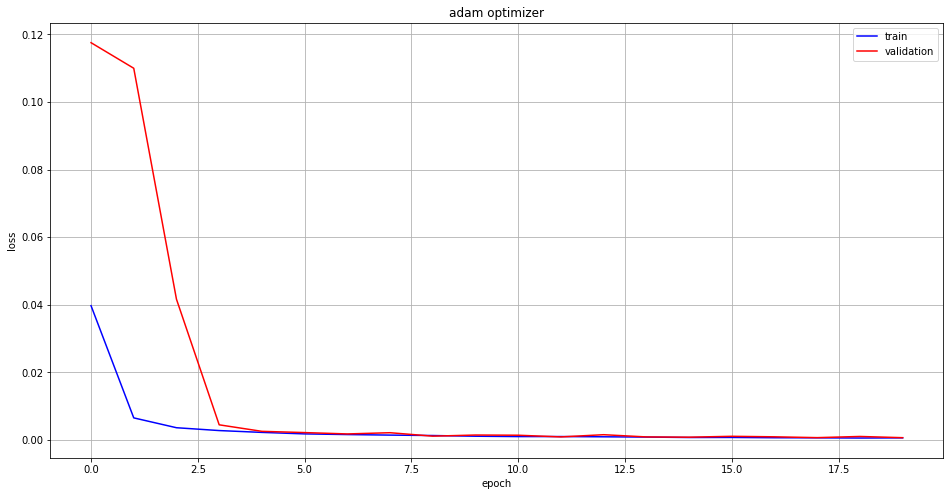

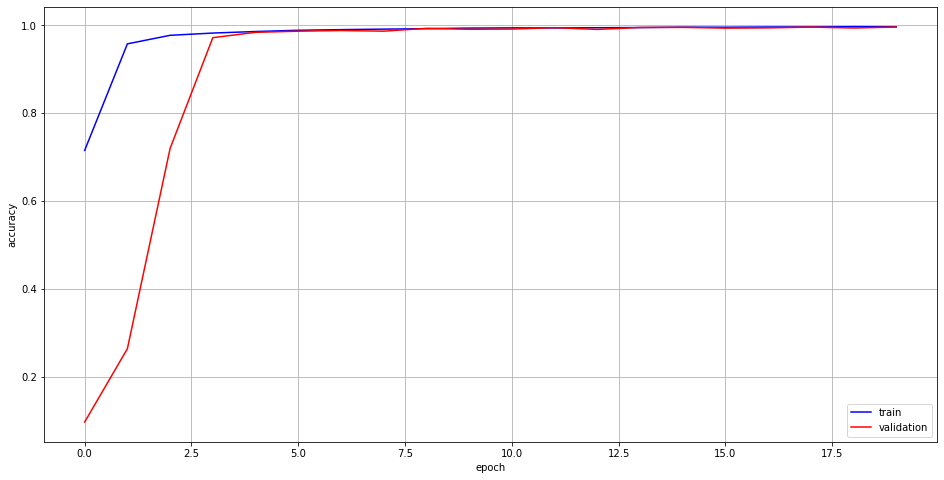

In [ ]:
# Plot the Loss finction for train & validation
fig = plt.figure(figsize=(16,8))
plt.plot(fitting.history['loss'],'b')
plt.plot(fitting.history['val_loss'],'r')
plt.title('adam optimizer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid()
# Plot the Accuracy
fig = plt.figure(figsize=(16,8))
plt.plot(fitting.history['accuracy'],'b')
plt.plot(fitting.history['val_accuracy'],'r')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid()

625/625 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

           0     0.9950    0.9910    0.9930      2000
           1     0.9906    0.9980    0.9943      2000
           2     0.9732    0.9970    0.9849      2000
           3     0.9954    0.9740    0.9846      2000
           4     0.9930    0.9930    0.9930      2000
           5     0.9950    0.9920    0.9935      2000
           6     0.9960    0.9935    0.9947      2000
           7     0.9990    0.9975    0.9982      2000
           8     0.9990    1.0000    0.9995      2000
           9     0.9945    0.9940    0.9942      2000

    accuracy                         0.9930     20000
   macro avg     0.9931    0.9930    0.9930     20000
weighted avg     0.9931    0.9930    0.9930     20000



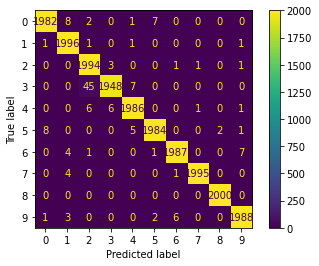

In [ ]:
y_pred= np.argmax(model.predict(X_test),axis=1)
y_t = np.argmax(y_test, axis=1)

print(classification_report(y_t, y_pred, digits=4))
print(ConfusionMatrixDisplay.from_predictions(y_t, y_pred))

# Adadelta optimizer with : learning_rate=1 , loss='MSE'

In [ ]:
model.compile(loss='MSE',optimizer=tf.optimizers.Adadelta(learning_rate=1),metrics=['accuracy'])
fitting=model.fit(X_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

Epoch 1/20
188/188 [==============================] - 30s 101ms/step - loss: 0.0121 - accuracy: 0.9231 - val_loss: 0.1767 - val_accuracy: 0.1002
Epoch 2/20
188/188 [==============================] - 16s 83ms/step - loss: 0.0029 - accuracy: 0.9829 - val_loss: 0.0090 - val_accuracy: 0.9472
Epoch 3/20
188/188 [==============================] - 16s 84ms/step - loss: 0.0021 - accuracy: 0.9876 - val_loss: 0.0018 - val_accuracy: 0.9895
Epoch 4/20
188/188 [==============================] - 16s 85ms/step - loss: 0.0015 - accuracy: 0.9908 - val_loss: 0.0038 - val_accuracy: 0.9792
Epoch 5/20
188/188 [==============================] - 16s 85ms/step - loss: 0.0014 - accuracy: 0.9917 - val_loss: 8.1444e-04 - val_accuracy: 0.9952
Epoch 6/20
188/188 [==============================] - 16s 84ms/step - loss: 0.0013 - accuracy: 0.9926 - val_loss: 0.0014 - val_accuracy: 0.9917
Epoch 7/20
188/188 [==============================] - 16s 84ms/step - loss: 9.8361e-04 - accuracy: 0.9942 - val_loss: 0.0032 - val_

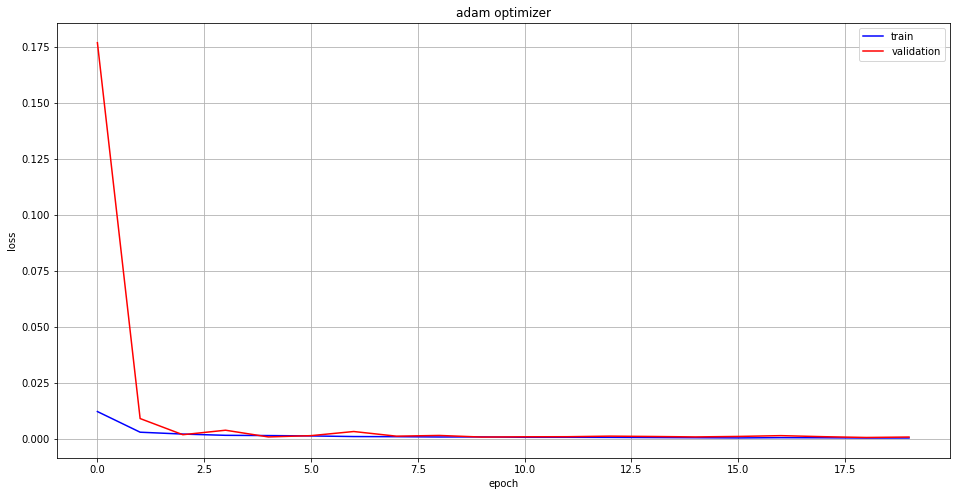

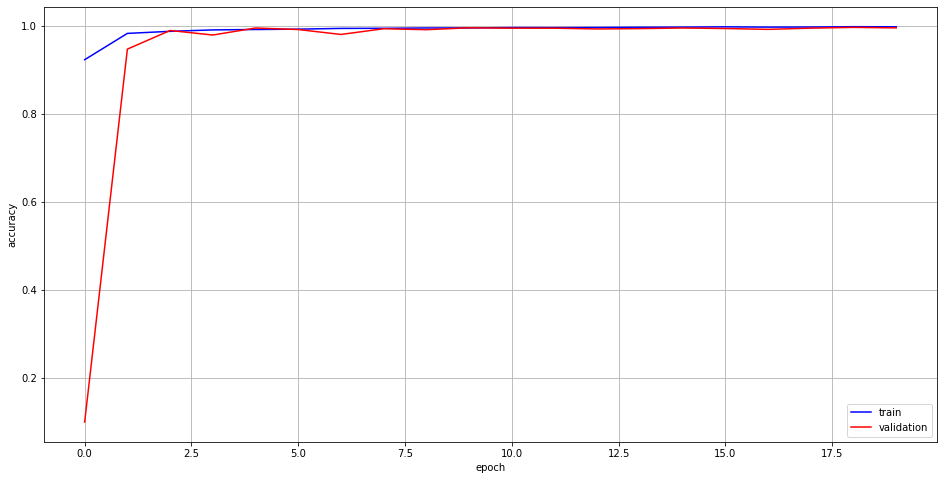

In [ ]:
# Plot the Loss finction for train & validation
fig = plt.figure(figsize=(16,8))
plt.plot(fitting.history['loss'],'b')
plt.plot(fitting.history['val_loss'],'r')
plt.title('adam optimizer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid()
# Plot the Accuracy
fig = plt.figure(figsize=(16,8))
plt.plot(fitting.history['accuracy'],'b')
plt.plot(fitting.history['val_accuracy'],'r')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid()

625/625 [==============================] - 4s 5ms/step
              precision    recall  f1-score   support

           0     0.9964    0.9710    0.9835      2000
           1     0.9822    0.9950    0.9886      2000
           2     0.9885    0.9910    0.9898      2000
           3     0.9930    0.9900    0.9915      2000
           4     0.9905    0.9945    0.9925      2000
           5     0.9803    0.9950    0.9876      2000
           6     0.9985    0.9855    0.9919      2000
           7     0.9960    0.9985    0.9973      2000
           8     1.0000    0.9985    0.9992      2000
           9     0.9891    0.9950    0.9920      2000

    accuracy                         0.9914     20000
   macro avg     0.9915    0.9914    0.9914     20000
weighted avg     0.9915    0.9914    0.9914     20000



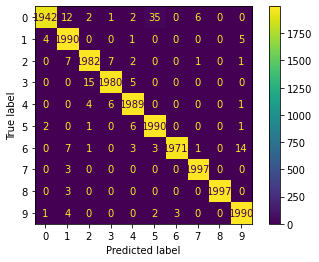

In [ ]:
y_pred= np.argmax(model.predict(X_test),axis=1)
y_t = np.argmax(y_test, axis=1)

print(classification_report(y_t, y_pred, digits=4))
print(ConfusionMatrixDisplay.from_predictions(y_t, y_pred))

# Momentum optimizer with : SGD(learning_rate=0.1, momentum=0.9) , loss='MSE'

In [8]:
model.compile(loss='MSE',optimizer=tf.optimizers.SGD(learning_rate=0.1, momentum=0.9),metrics=['accuracy'])
fitting=model.fit(X_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

Epoch 1/20
188/188 [==============================] - 29s 99ms/step - loss: 0.0223 - accuracy: 0.8396 - val_loss: 0.1490 - val_accuracy: 0.1015
Epoch 2/20
188/188 [==============================] - 15s 81ms/step - loss: 0.0037 - accuracy: 0.9763 - val_loss: 0.0420 - val_accuracy: 0.7200
Epoch 3/20
188/188 [==============================] - 15s 81ms/step - loss: 0.0027 - accuracy: 0.9829 - val_loss: 0.0033 - val_accuracy: 0.9787
Epoch 4/20
188/188 [==============================] - 16s 85ms/step - loss: 0.0021 - accuracy: 0.9869 - val_loss: 0.0015 - val_accuracy: 0.9907
Epoch 5/20
188/188 [==============================] - 16s 85ms/step - loss: 0.0017 - accuracy: 0.9893 - val_loss: 0.0013 - val_accuracy: 0.9923
Epoch 6/20
188/188 [==============================] - 16s 83ms/step - loss: 0.0015 - accuracy: 0.9906 - val_loss: 0.0010 - val_accuracy: 0.9938
Epoch 7/20
188/188 [==============================] - 16s 83ms/step - loss: 0.0013 - accuracy: 0.9923 - val_loss: 0.0011 - val_accuracy:

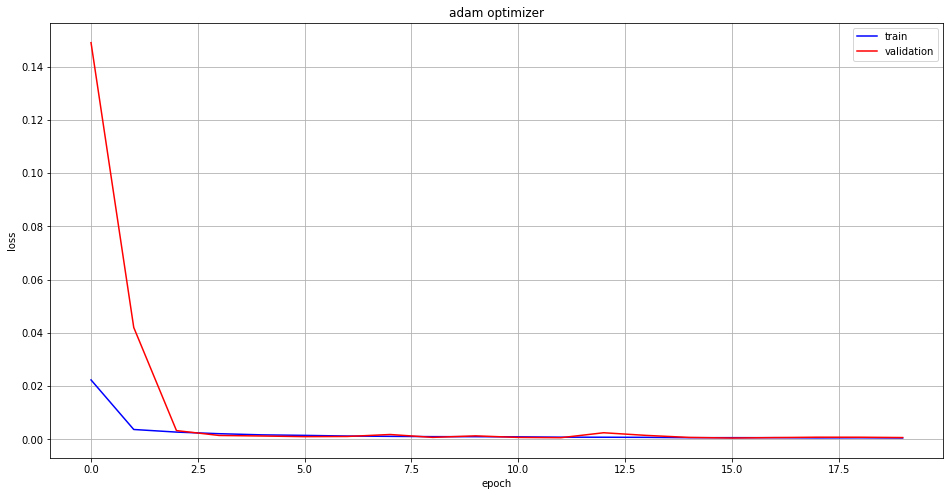

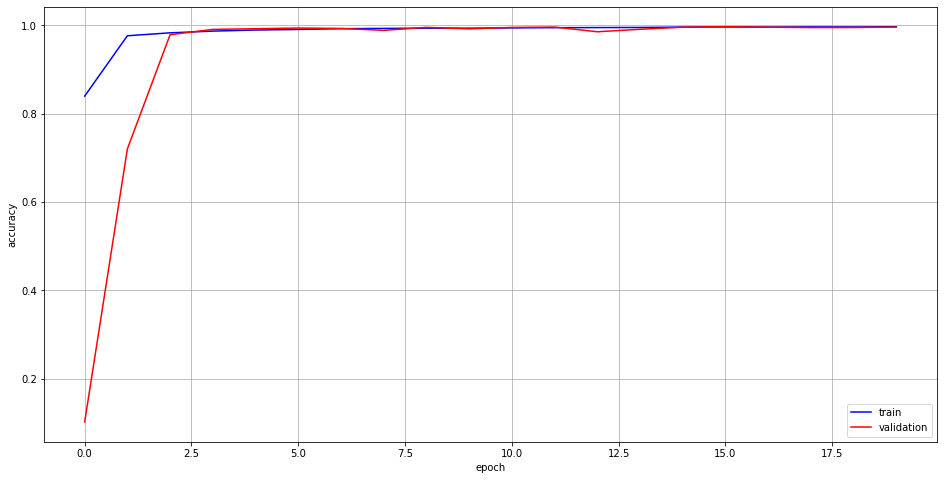

In [9]:
# Plot the Loss finction for train & validation
fig = plt.figure(figsize=(16,8))
plt.plot(fitting.history['loss'],'b')
plt.plot(fitting.history['val_loss'],'r')
plt.title('adam optimizer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid()
# Plot the Accuracy
fig = plt.figure(figsize=(16,8))
plt.plot(fitting.history['accuracy'],'b')
plt.plot(fitting.history['val_accuracy'],'r')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid()

625/625 [==============================] - 4s 5ms/step
              precision    recall  f1-score   support

           0     0.9920    0.9875    0.9897      2000
           1     0.9856    0.9955    0.9905      2000
           2     0.9764    0.9935    0.9849      2000
           3     0.9984    0.9650    0.9814      2000
           4     0.9765    0.9985    0.9874      2000
           5     0.9886    0.9935    0.9910      2000
           6     0.9975    0.9885    0.9930      2000
           7     0.9990    0.9950    0.9970      2000
           8     0.9995    0.9990    0.9992      2000
           9     0.9950    0.9915    0.9932      2000

    accuracy                         0.9908     20000
   macro avg     0.9909    0.9908    0.9907     20000
weighted avg     0.9909    0.9908    0.9907     20000



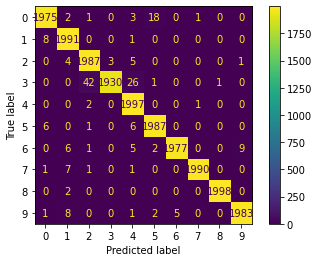

In [10]:
y_pred= np.argmax(model.predict(X_test),axis=1)
y_t = np.argmax(y_test, axis=1)

print(classification_report(y_t, y_pred, digits=4))
print(ConfusionMatrixDisplay.from_predictions(y_t, y_pred))